## Início

- Link do Kaggle: https://www.kaggle.com/datasets/subhajournal/iotintrusion
- Link do CIC: http://205.174.165.80/IOTDataset/CIC_IOT_Dataset2023/Dataset/
- Comando usado: `lftp -c 'mirror --parallel=100 --use-pget-n=10 --exclude-glob *.pcap --exclude PCAP/* <link-d> ;exit'`

In [1]:
import os
import pickle
import nfstream

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
%xmode minimal

Exception reporting mode: Minimal


In [5]:
%config InlineBackend.figure_format='retina'

In [6]:
pd.set_option("styler.format.thousands", ",")
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [7]:
import session_info
session_info.show()

## Puxando do Kaggle

In [8]:
df = pd.read_csv('kaggle/IoT_Intrusion.csv')
"entradas: {:,}".format(len(df))

'entradas: 1,048,575'

In [9]:
f"classes: {df['label'].nunique()}"

'classes: 34'

## Puxando dos Arquivos

<center>
     <img src="images/entradas-classe.png" alt="entradas em cada classe"> 
</center>

In [10]:
from pathlib import Path
PATH = Path("/data/CICIoT2023/CSV")

PosixPath('/data/CICIoT2023/CSV')

In [11]:
csv_files = [file for subfolder in PATH.iterdir()
             for file in subfolder.glob("*.csv")]

f"Quantidade de arquivos: {len(csv_files)}"

'Quantidade de arquivos: 296'

In [12]:
data_frames = [pd.read_csv(file.resolve(), low_memory=False)
               for file in csv_files]
combined_df = pd.concat(data_frames, ignore_index=True)
memory = combined_df.memory_usage(index=True).sum() / (1024 ** 3)

print(f"""
Quantidade de Linhas: {len(combined_df):,}
Memória:              {memory:.2f}GB
""")



Quantidade de Linhas: 46,737,266
Memória:              13.58GB



## Tamanhos das classes

In [13]:
if os.path.isfile('pickles/class_names.pkl'):
    with open('pickles/class_names.pkl', 'rb') as f:
        class_names = pickle.load(f)

if os.path.isfile('pickles/class_sizes.pkl'):
    with open('pickles/class_sizes.pkl', 'rb') as f:
        class_sizes = pickle.load(f)

if not (class_sizes and class_names):
    parent_folder_path = "/home/jp/Documents/IC/CICIoT2023/CSV/"
    class_sizes = []
    class_names = []
    for class_name in os.listdir(parent_folder_path):
        class_folder_path = os.path.join(parent_folder_path, class_name)
        if os.path.isdir(class_folder_path):
            csv_files = [f for f in os.listdir(class_folder_path) if f.endswith('.csv')]
            total_rows = 0
            for file in csv_files:
                file_path = os.path.join(class_folder_path, file)
                df = pd.read_csv(file_path)
                total_rows += len(df)
                del df
            
            class_sizes.append(total_rows)
            class_names.append(class_name)
            
            with open('pickles/sclass_sizes.pkl', 'wb') as f:
                pickle.dump(class_sizes, f)
            with open('pickles/class_names.pkl', 'wb') as f:
                pickle.dump(class_names, f)

In [14]:
print(f"Quantidade de classes puxando dos arquivos diretamente: {len(class_names)}")

Quantidade de classes puxando dos arquivos diretamente: 34


In [15]:
class_sizes_series = pd.Series(class_sizes, index=class_names)
class_sizes_series_sorted = class_sizes_series.sort_values()
class_sizes_series_sorted_formatted = class_sizes_series_sorted.apply(lambda x: f"{x:,}")

DDoS-ACK_Fragmentation             0
Uploading_Attack               1,252
Recon-PingSweep                2,262
Backdoor_Malware               3,218
XSS                            3,846
SqlInjection                   5,245
CommandInjection               5,409
BrowserHijacking               5,859
DictionaryBruteForce          13,064
DDoS-SlowLoris                23,426
DDoS-HTTP_Flood               28,790
DoS-HTTP_Flood                71,861
Recon-PortScan                82,284
Recon-OSScan                  98,259
Recon-HostDiscovery          134,378
DNS_Spoofing                 178,898
DDoS-UDP_Fragmentation       286,925
MITM-ArpSpoofing             307,560
VulnerabilityScan            373,351
DDoS-ICMP_Fragmentation      452,490
Mirai-greip_flood            751,646
Mirai-udpplain               890,574
Mirai-greeth_flood           991,834
Benign_Final               1,098,191
DoS-SYN_Flood              2,028,836
DoS-TCP_Flood              2,671,430
DoS-UDP_Flood              3,318,634
D

---

Zero entradas?

<center>
     <img src="images/DDoS-ACK_Fragmentation-sem-entradas.png" alt="entradas em cada classe"> 
</center>

In [16]:
"tamanho total faltante: {:.1f}GB".format(1.9 * 12 + 0.816)

'tamanho total faltante: 23.6GB'

Solução: **desconsiderar os ataques volumétricos**

## Distribuição das classes

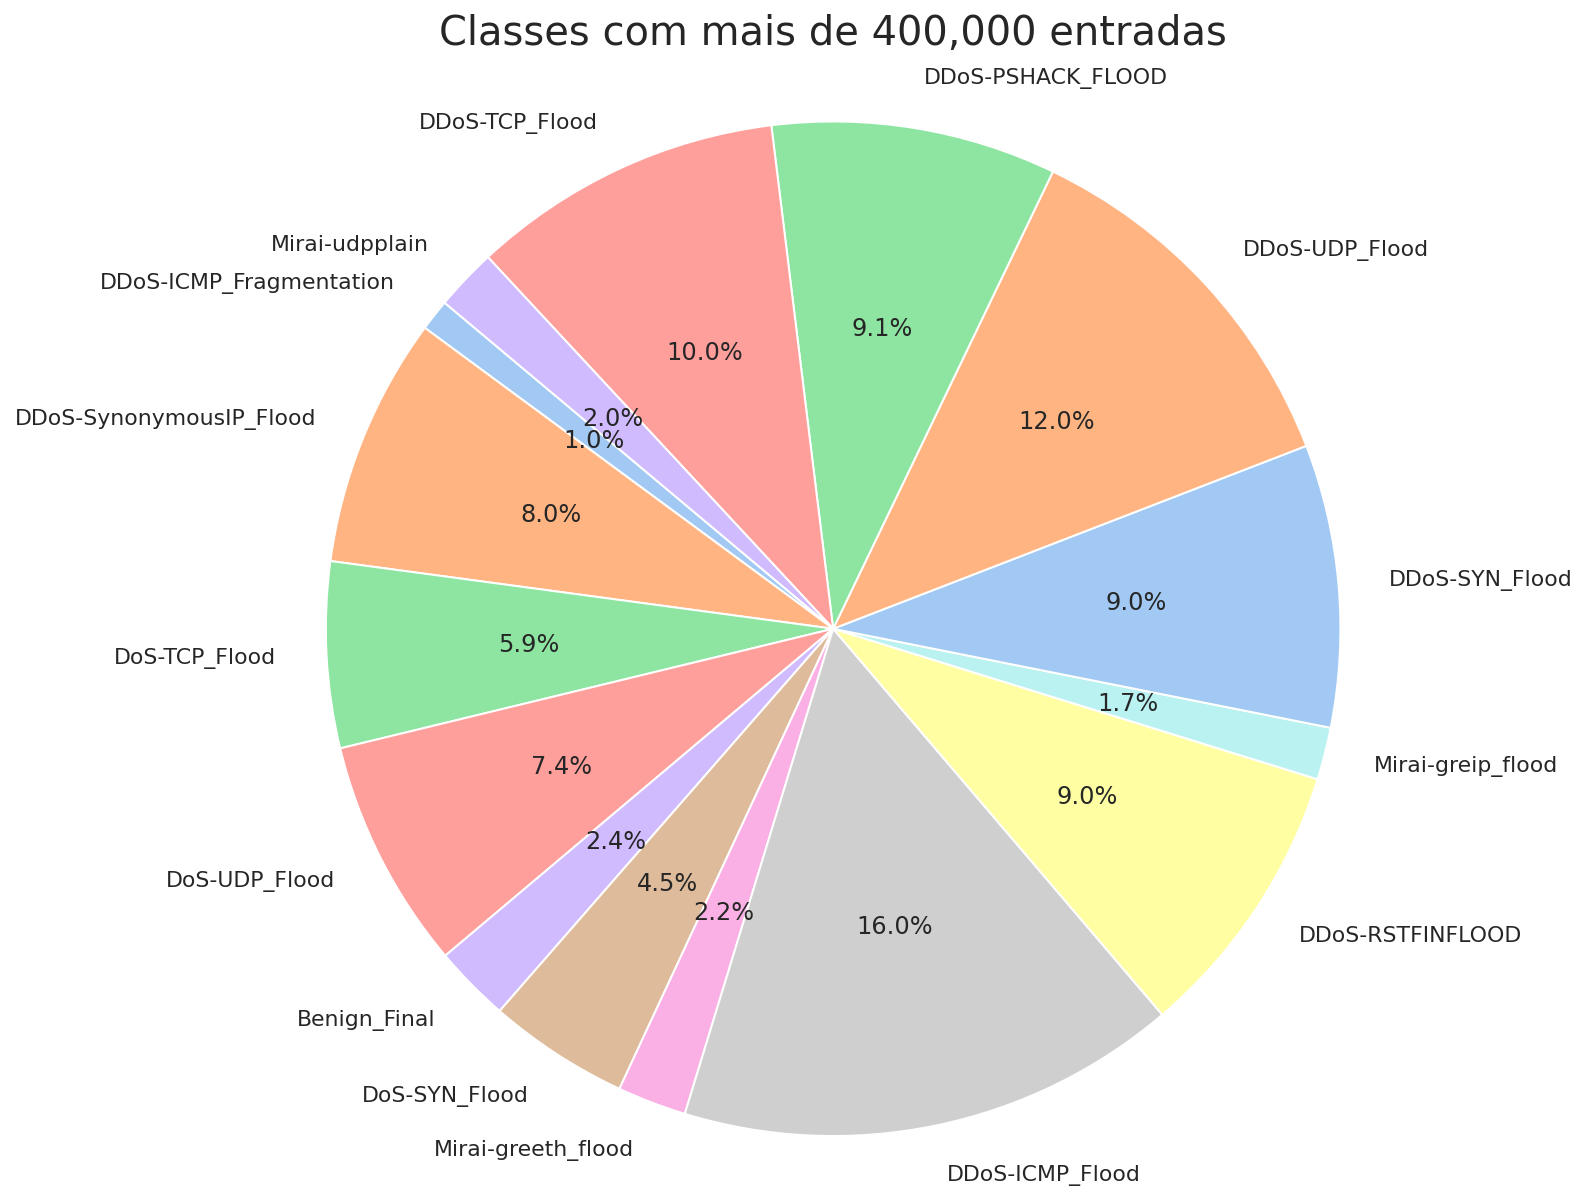

In [17]:
data = {'Class': class_names, 'Size': class_sizes}
df_classes_distribution = pd.DataFrame(data)
df_classes_distribution = df_classes_distribution[df_classes_distribution['Size'] > 400_000]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))

plt.pie(df_classes_distribution['Size'], 
        labels=df_classes_distribution['Class'], 
        autopct='%1.1f%%',
        startangle=140, 
        colors=sns.color_palette("pastel"))

plt.title('Classes com mais de 400,000 entradas', fontsize = 20, pad = 20)
plt.axis('equal')
plt.show()

Ainda com o filtro, sobram muitas classes

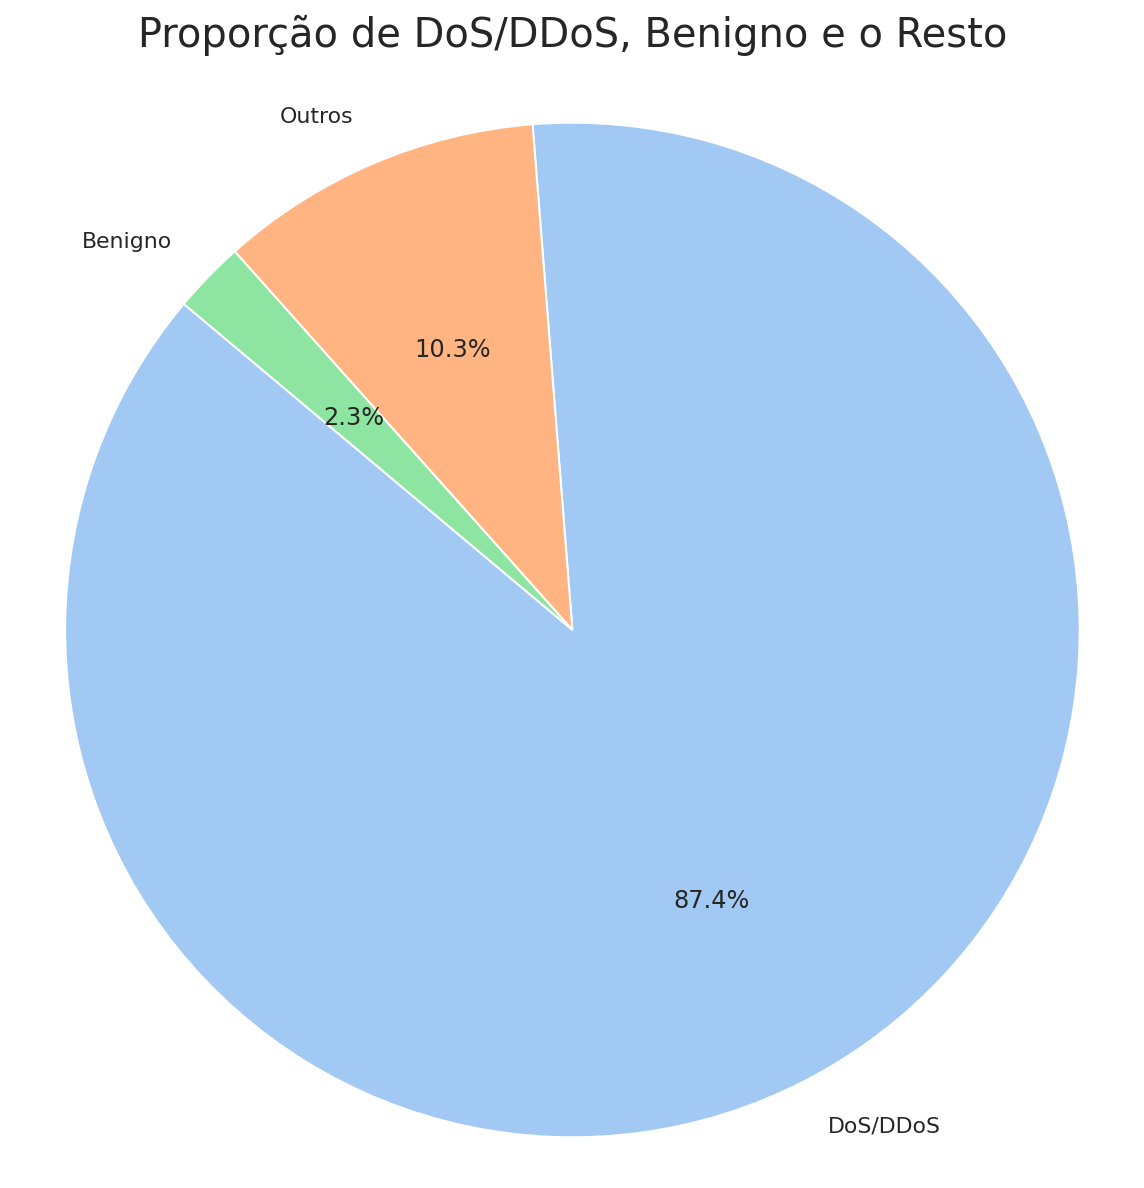

In [18]:
data = {'Class': class_names, 'Size': class_sizes}
df_classes_distribution = pd.DataFrame(data)

dos_ddos_classes = [name for name in class_names if 'DoS' in name or 'DDoS' in name]

dos_ddos_size = df_classes_distribution[df_classes_distribution['Class'].isin(dos_ddos_classes)]['Size'].sum()
other_size = df_classes_distribution[~df_classes_distribution['Class'].isin(dos_ddos_classes)]['Size'].sum()
benign_size = df_classes_distribution[df_classes_distribution['Class'].str.contains('Benign')]['Size'].sum()

pie_data = pd.DataFrame({
    'Category': ['DoS/DDoS', 'Outros', 'Benigno'],
    'Size': [dos_ddos_size, other_size, benign_size]
})

sns.set(style="whitegrid")

plt.figure(figsize=(10, 10))
plt.pie(pie_data['Size'], 
        labels=pie_data['Category'], 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=sns.color_palette("pastel"))

plt.title('Proporção de DoS/DDoS, Benigno e o Resto', fontsize = 20, pad = 20)
plt.axis('equal')
plt.show()

A proporção dos volumétricos é muito desigual

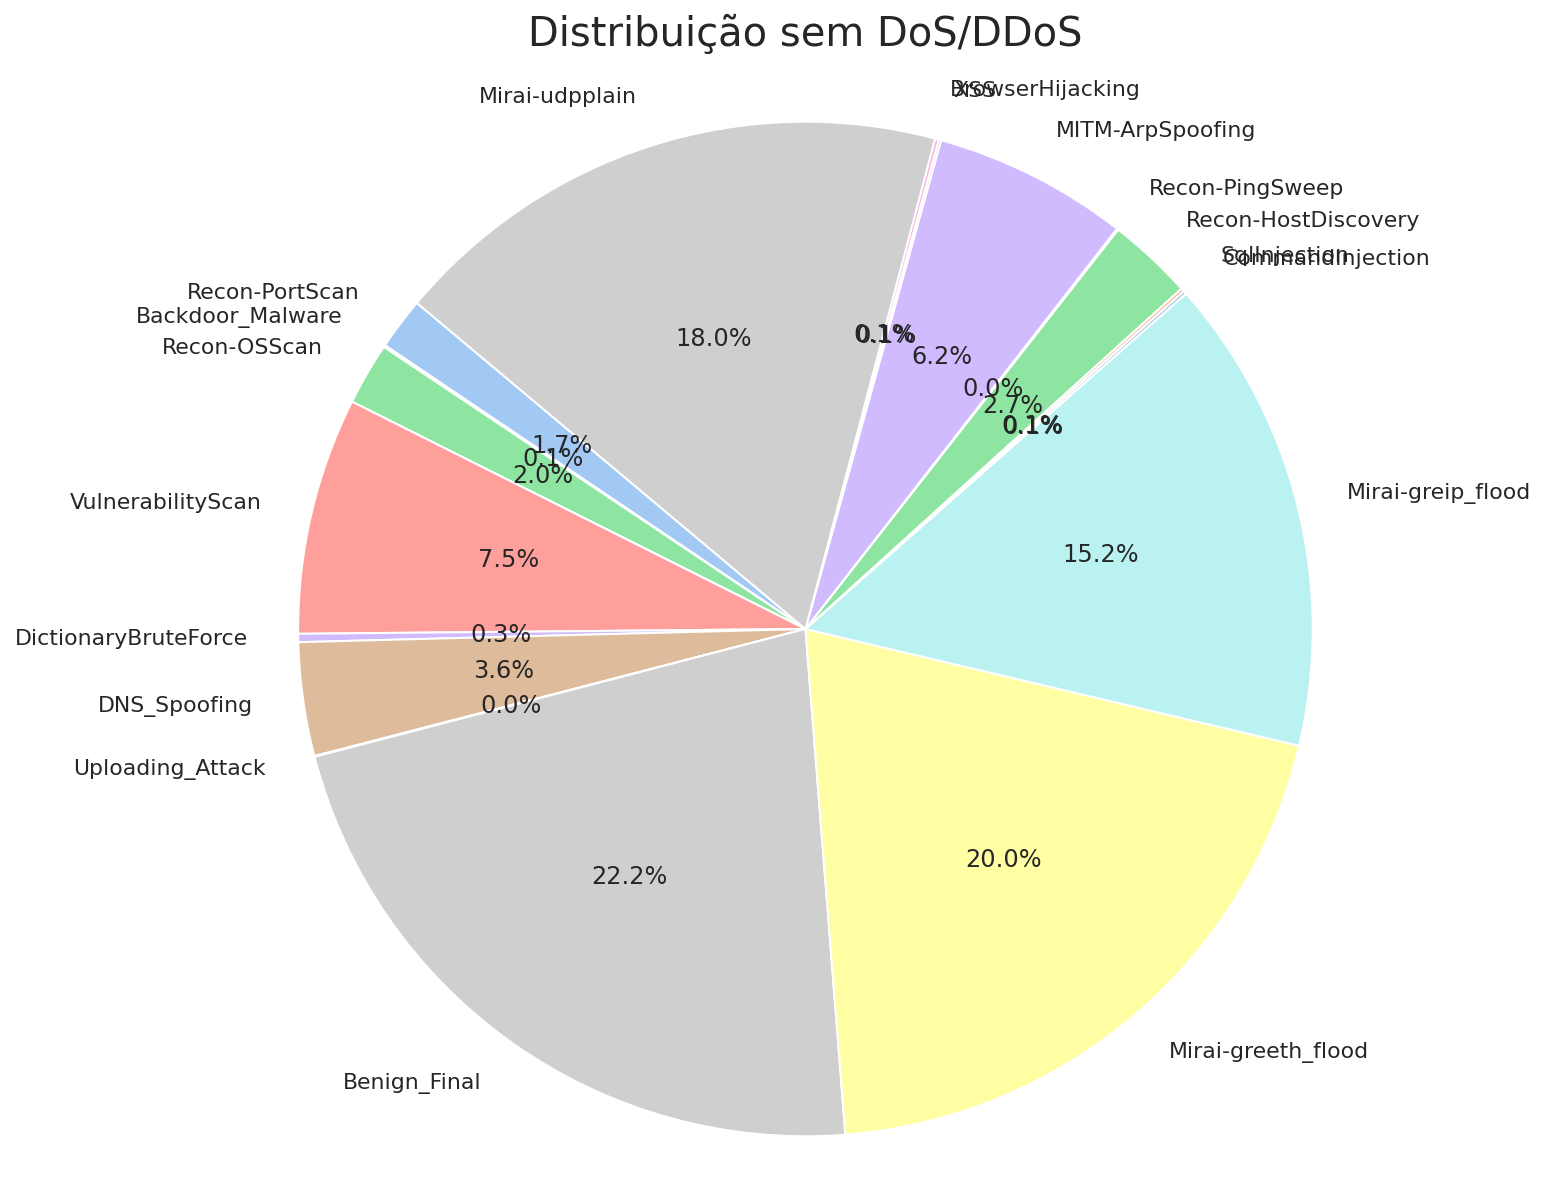

In [19]:
data = {'Class': class_names, 'Size': class_sizes}
df_classes_distribution = pd.DataFrame(data)
df_classes_distribution = df_classes_distribution[~df_classes_distribution['Class'].str.contains("DoS|DDoS")]
# df_classes_distribution = df_classes_distribution[df_classes_distribution['Size'] > 5_400]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))

plt.pie(df_classes_distribution['Size'], 
        labels=df_classes_distribution['Class'], 
        autopct='%1.1f%%',
        startangle=140, 
        colors=sns.color_palette("pastel"))

plt.title('Distribuição sem DoS/DDoS', fontsize = 20, pad = 20)
plt.axis('equal')
plt.show()

Tirando eles, ainda fica muito espalhado. Vamos tentar filtrar novamente

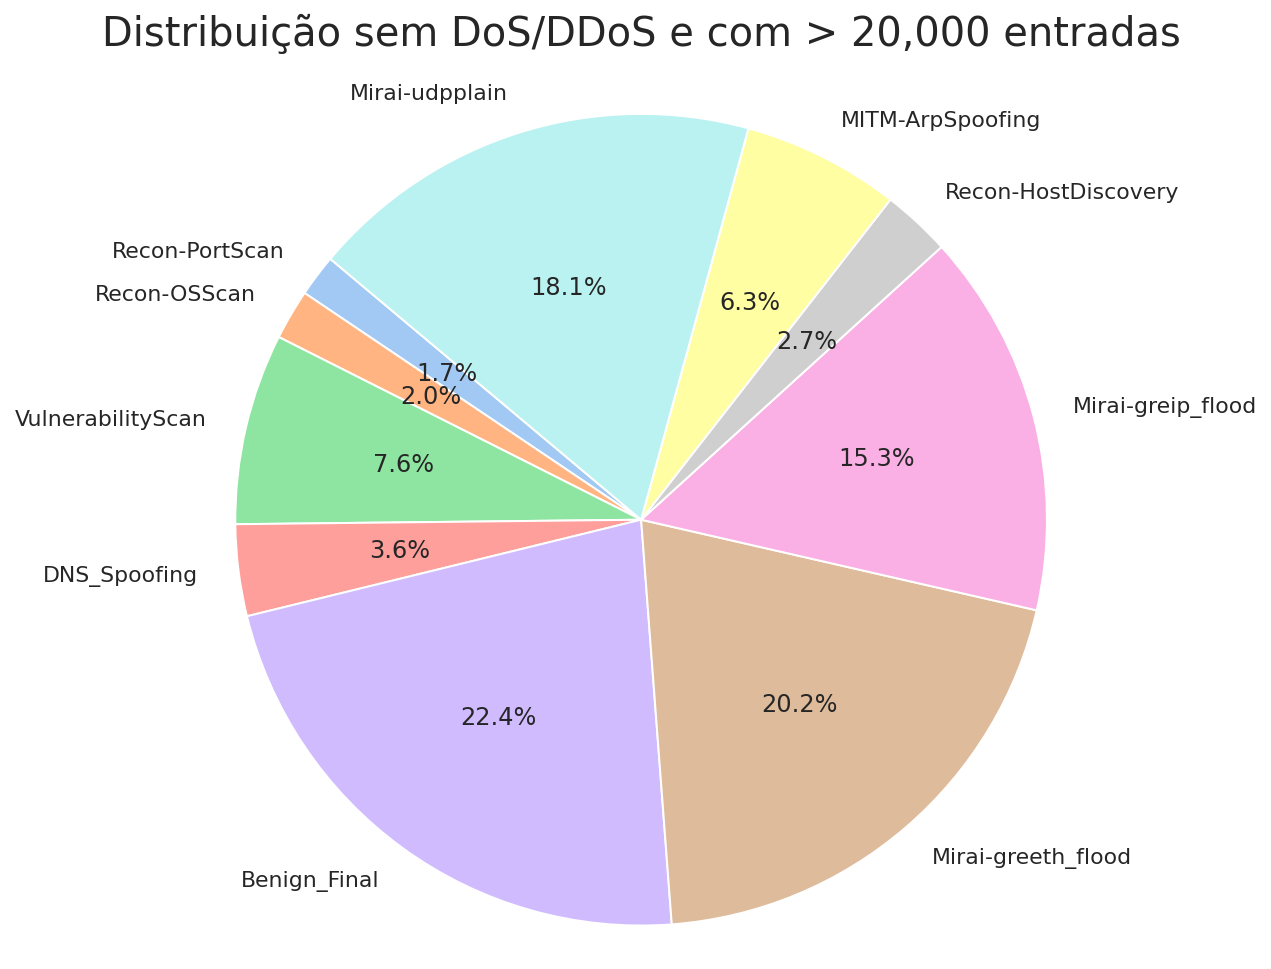

In [20]:
data = {'Class': class_names, 'Size': class_sizes}
df_classes_distribution = pd.DataFrame(data)
df_classes_distribution = df_classes_distribution[~df_classes_distribution['Class'].str.contains("DoS|DDoS")]
df_classes_distribution = df_classes_distribution[df_classes_distribution['Size'] > 20_000]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))

plt.pie(df_classes_distribution['Size'], 
        labels=df_classes_distribution['Class'], 
        autopct='%1.1f%%',
        startangle=140, 
        colors=sns.color_palette("pastel"))

plt.title('Distribuição sem DoS/DDoS e com > 20,000 entradas', fontsize = 20, pad = 20)
plt.axis('equal')
plt.show()

A natureza do dataset sugere uma seleção de classes

## Fim